In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import cv2 as cv2

import torch
import torch.hub

import torchvision
import torchvision.utils

from data import dataset as data
import data.utils as data_utils
import attack_construction.attack_methods as attack_methods
import attack_construction.metrics as metrics
import attack_construction.utils as attack_utils
import pickle

print(torch.__version__)
print(torch.cuda_version)
print(torchvision.__version__)

1.10.0+cu113
11.3
0.11.1+cu113


In [2]:
device = torch.device("cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model = model.float().to(device)

dataset = data.AdversarialDataset() # todo: use resize to pull picture in batch

loss = am.lossObjectness

patch = utils.LoadPatch("patch - meme")

In [7]:
patch = am.generatePatch()

In [4]:
image, label = dataset[8]
utils.testPatch(patch, image, label, model, device, loss, 0.8)

C:\Users\Степан\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: The size of tensor a (3) must match the size of tensor b (200) at non-singleton dimension 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


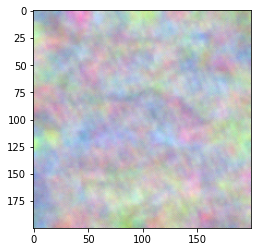

In [3]:
utils.ShowPatch(patch.cpu())

In [15]:
cv2.imwrite('patch.png', cv2.cvtColor(data.TenToIm(patch.clone().detach().to(torch.device("cpu"))), cv2.COLOR_RGB2BGR))

True

sh script (path dataset, patch size, )

In [3]:
image = cv2.imread("girl_with_boobs.jpg")
image = cv2.resize(image, (int(image.shape[1]*0.5), int(image.shape[0]*0.5)))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = [[50,120,300,500]]
utils.testPatch(patch, image, label, model, device, loss, 0.8)

C:\Users\Степан\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


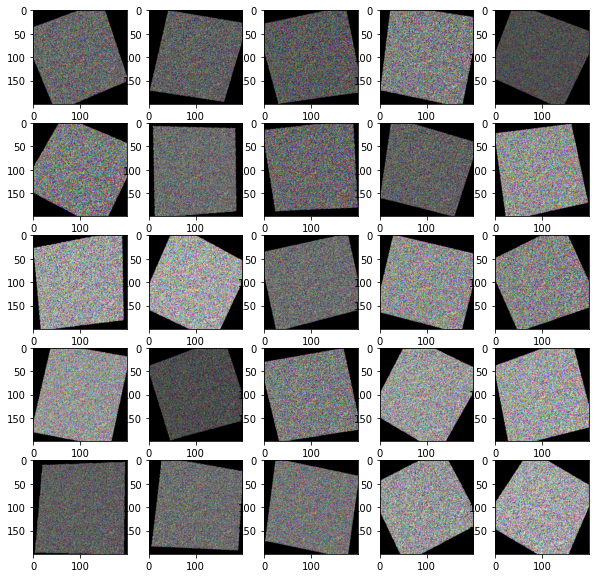

In [8]:
augmentations = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.05),
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.3)),
        torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        torchvision.transforms.RandomRotation(degrees=(-30, 30)),
    ])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    utils.ShowPatch(augmentations(patch))